In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
from surprise.model_selection import train_test_split,cross_validate,KFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("ratings_Electronics.csv",names=['user_id', 'product_id','rating','timestamp'])
data.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
data.shape

(7824482, 4)

In [4]:
data.isnull().sum()

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
### Taking subset of dataset

data=data.iloc[:1048576,0:]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1048576 non-null  object 
 1   product_id  1048576 non-null  object 
 2   rating      1048576 non-null  float64
 3   timestamp   1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='rating', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Product Ratings')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

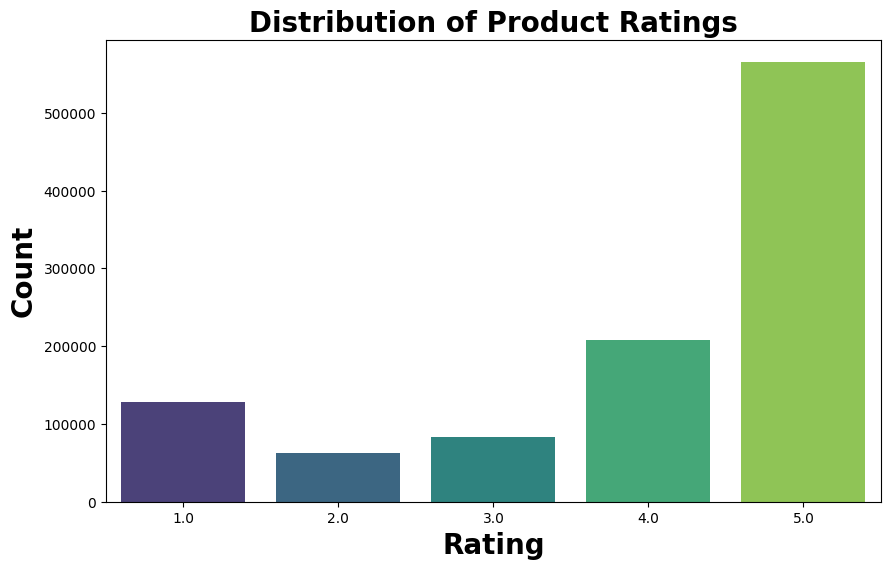

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='rating', palette='viridis')
plt.title('Distribution of Product Ratings',fontweight='bold',fontsize=20)
plt.xlabel('Rating',fontweight='bold',fontsize=20)
plt.ylabel('Count',fontweight='bold',fontsize=20)
plt.show()

In [9]:
data.rating.value_counts()

5.0    565637
4.0    208535
1.0    128251
3.0     83509
2.0     62644
Name: rating, dtype: int64

In [10]:
print("Total no of ratings : ",data.shape[0])
print("Total No of users   : ", data.user_id.nunique())
print("Total No of products  : ", data.product_id.nunique())

Total no of ratings :  1048576
Total No of users   :  786330
Total No of products  :  61894


In [11]:
data.drop(['timestamp'], axis=1,inplace=True)

In [12]:
ratings_per_user = data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

ratings_per_user.head()

user_id
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: rating, dtype: int64

In [13]:
ratings_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: rating, dtype: float64

In [14]:
# Find no of users having given at least 50 ratings

print('Total No of Users : ',data.user_id.nunique())
print('No of users having given at least 50 ratings : ',sum(ratings_per_user >= 50)) 

Total No of Users :  786330
No of users having given at least 50 ratings :  38


# Recommender - Popularity Based

In [15]:
ratings_per_product = data.groupby(by='product_id')['rating'].count().sort_values(ascending=False)
ratings_per_product

product_id
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
              ... 
B00009UT62       1
B00009UT6A       1
B000ARISWK       1
B000ARHONE       1
0132793040       1
Name: rating, Length: 61894, dtype: int64

In [16]:
ratings_per_product.head(20)

product_id
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
B000B9RI14    2996
B000A6PPOK    2828
B00007M1TZ    2608
B00004ZCJE    2547
B000CSWCQA    2441
B000652M6Y    2152
B00020S7XK    2140
B0007MXZB2    2080
B00001P4ZH    2075
B00093IIRA    2014
B00009R6TA    1978
B000BTL0OA    1965
B00007E7C8    1962
B000CKVOOY    1873
Name: rating, dtype: int64

In [17]:
### Find no of products having at least 50 ratings

print('Total No of products : ',data.product_id.nunique())
print('No of products having given at least 50 ratings : ',sum(ratings_per_product >= 50)) 

Total No of products :  61894
No of products having given at least 50 ratings :  3813


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

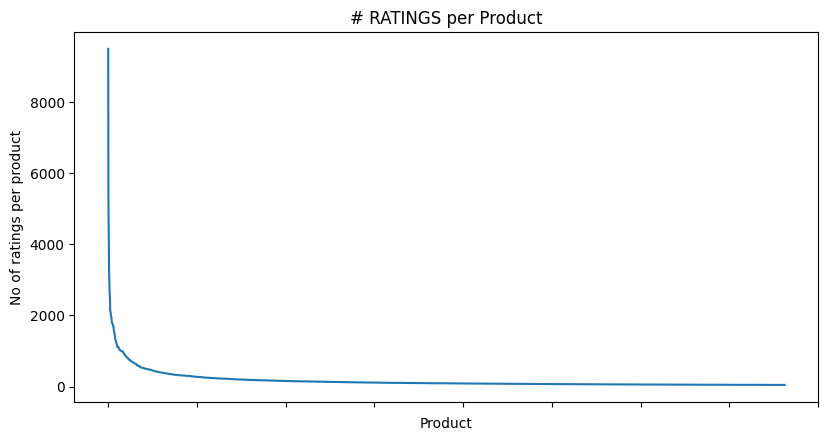

In [18]:
# Filter products with at least 50 ratings

new_df = data.groupby("product_id").filter(lambda x: x['rating'].count() >= 50)

# Number of ratings per product

no_of_ratings_per_product = new_df.groupby(by='product_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [19]:
print(new_df.groupby('product_id')['rating'].mean().head())

product_id
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: rating, dtype: float64


In [20]:
#Average rating of the product 

print(new_df.groupby('product_id')['rating'].mean().head())

product_id
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: rating, dtype: float64


In [21]:
# Highest average ratings
print(new_df.groupby('product_id')['rating'].mean().sort_values(ascending=False).head())

product_id
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: rating, dtype: float64


In [22]:
# Total number of ratings for product
print(new_df.groupby('product_id')['rating'].count().sort_values(ascending=False).head())

product_id
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: rating, dtype: int64


In [23]:
# Ratings mean, count
ratings_mean_count = new_df.groupby('product_id')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'average_rating', 'count': 'rating_counts'})
print(ratings_mean_count.head())

print("Max rating count:", ratings_mean_count['rating_counts'].max())

            average_rating  rating_counts
product_id                               
0972683275        4.470980           1051
1400501466        3.560000            250
1400501520        4.243902             82
1400501776        3.884892            139
1400532620        3.684211            171
Max rating count: 9487


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Distribution of Rating Counts')

Text(0.5, 0, 'Rating Counts')

Text(0, 0.5, 'Frequency')

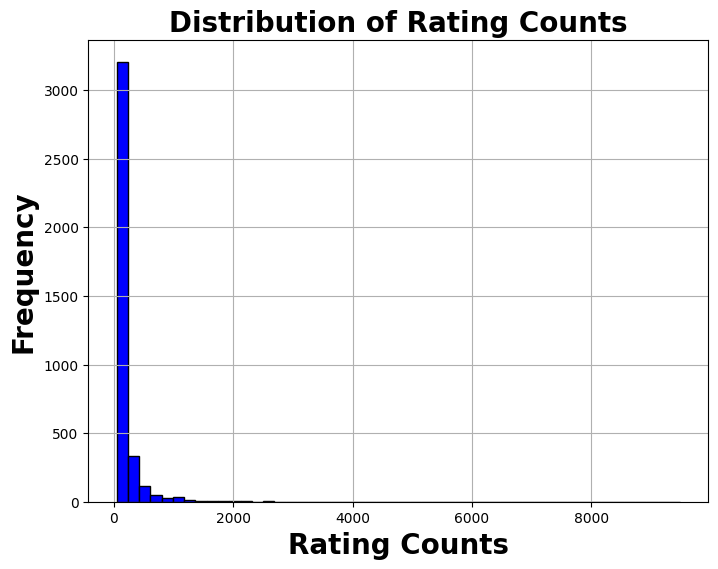

In [24]:
plt.figure(figsize=(8, 6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50, color='blue')
plt.title('Distribution of Rating Counts',fontweight='bold',fontsize=20)
plt.xlabel('Rating Counts',fontweight='bold',fontsize=20)
plt.ylabel('Frequency',fontweight='bold',fontsize=20)
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Distribution of Average Ratings')

Text(0.5, 0, 'Average Rating')

Text(0, 0.5, 'Frequency')

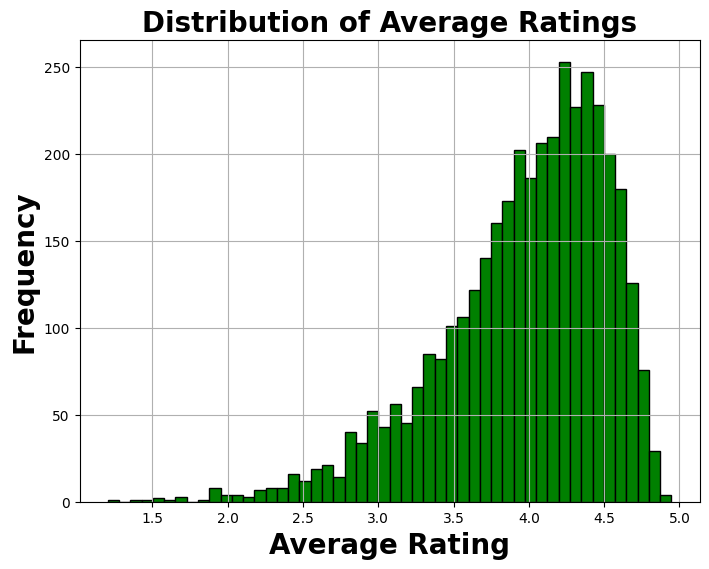

In [25]:
plt.figure(figsize=(8, 6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['average_rating'].hist(bins=50, color='green')
plt.title('Distribution of Average Ratings',fontweight='bold',fontsize=20)
plt.xlabel('Average Rating',fontweight='bold',fontsize=20)
plt.ylabel('Frequency',fontweight='bold',fontsize=20)
plt.show()

<Axes: xlabel='product_id'>

Text(0.5, 1.0, 'Top 30 Most Popular Products')

Text(0.5, 0, 'Product ID')

Text(0, 0.5, 'Number of Ratings')

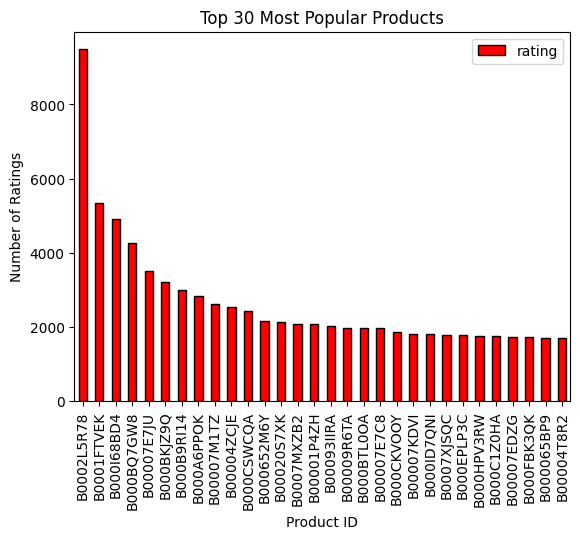

In [26]:
popular_products = pd.DataFrame(new_df.groupby('product_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind="bar", color='red')

plt.title('Top 30 Most Popular Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Ratings')
plt.show()

# Collaberative filtering : Item Recommender based on Similar User Ratings

# SVD

In [33]:
from surprise import KNNWithMeans, KNNBasic, Dataset, Reader, accuracy, SVD
from surprise.model_selection import train_test_split
import pandas as pd

In [34]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df[['user_id', 'product_id', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)

In [36]:
algo=SVD()

In [37]:
def train_test_in_batches(data, algo, batch_size=10000):
    raw_ratings = data.raw_ratings
    np.random.shuffle(raw_ratings)
    
    total_rmse = 0
    num_batches = len(raw_ratings) // batch_size + (1 if len(raw_ratings) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(raw_ratings))
        batch = raw_ratings[start:end]
        
        # Convert batch to DataFrame
        batch_df = pd.DataFrame(batch, columns=['user_id', 'product_id', 'rating', 'timestamp'])
        batch_df = batch_df[['user_id', 'product_id', 'rating']]  # Select only the required columns
        
        # Create a temporary dataset for the current batch
        temp_data = Dataset.load_from_df(batch_df, reader)
        temp_trainset = temp_data.build_full_trainset()
        temp_testset = temp_trainset.build_testset()
        
        algo.fit(temp_trainset)
        predictions = algo.test(temp_testset)
        
        batch_rmse = accuracy.rmse(predictions, verbose=False)
        total_rmse += batch_rmse
        
        print(f"Batch {i + 1}/{num_batches} RMSE: {batch_rmse}")
    
    avg_rmse = total_rmse / num_batches
    return avg_rmse

# Calculate and print overall RMSE
overall_rmse = train_test_in_batches(data, algo, batch_size=10000)
print(f"Overall RMSE: {overall_rmse}")

Batch 1/68 RMSE: 0.9088458229806653
Batch 2/68 RMSE: 0.8969048829412951
Batch 3/68 RMSE: 0.896870672113793
Batch 4/68 RMSE: 0.9042541605550445
Batch 5/68 RMSE: 0.8881194800165463
Batch 6/68 RMSE: 0.8970373288536097
Batch 7/68 RMSE: 0.9018216653563247
Batch 8/68 RMSE: 0.9027618960037427
Batch 9/68 RMSE: 0.8942445702610302
Batch 10/68 RMSE: 0.8975374122653239
Batch 11/68 RMSE: 0.8959780443218643
Batch 12/68 RMSE: 0.8965013314213315
Batch 13/68 RMSE: 0.8935949675675727
Batch 14/68 RMSE: 0.9098925313839407
Batch 15/68 RMSE: 0.9016050901437397
Batch 16/68 RMSE: 0.893712903292068
Batch 17/68 RMSE: 0.9048550822700638
Batch 18/68 RMSE: 0.8994669662116141
Batch 19/68 RMSE: 0.9019646610360782
Batch 20/68 RMSE: 0.8931928512746367
Batch 21/68 RMSE: 0.9024608499051622
Batch 22/68 RMSE: 0.9048272674528105
Batch 23/68 RMSE: 0.8976823497605462
Batch 24/68 RMSE: 0.8969244865246638
Batch 25/68 RMSE: 0.9011972062520894
Batch 26/68 RMSE: 0.8982758683371336
Batch 27/68 RMSE: 0.8950000783361082
Batch 28/68 

# Product Based Filtering 

In [41]:
np.int=int
algo_knn_means = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_knn_basic = KNNBasic(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

def fit_in_batches(trainset, algo, batch_size=1000):
    # Get raw ratings from the training set
    raw_ratings = trainset.build_testset()
    np.random.shuffle(raw_ratings)
    
    num_batches = len(raw_ratings) // batch_size + (1 if len(raw_ratings) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(raw_ratings))
        batch = raw_ratings[start:end]
        
        # Create a temporary dataset for the current batch
        temp_trainset = Dataset.load_from_df(pd.DataFrame(batch, columns=['user', 'item', 'rating']), reader).build_full_trainset()
        
        algo.fit(temp_trainset)
        
        print(f"Batch {i + 1}/{num_batches} fitted")

def evaluate_model(algo, testset):
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    return rmse


print("Processing with KNNWithMeans for item based filtering...")
fit_in_batches(trainset, algo_knn_means, batch_size=1000)
overall_rmse_knn_means = evaluate_model(algo_knn_means, testset)
print(f"Overall RMSE for KNNWithMeans: {overall_rmse_knn_means}")


print("Processing with KNNBasic for item based filtering...")
fit_in_batches(trainset, algo_knn_basic, batch_size=1000)
overall_rmse_knn_basic = evaluate_model(algo_knn_basic, testset)
print(f"Overall RMSE for KNNBasic: {overall_rmse_knn_basic}")

Processing with KNNWithMeans for item based filtering...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 1/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 2/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 3/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 4/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 5/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 6/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 7/54

Done computing similarity matrix.
Batch 62/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 63/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 64/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 65/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 66/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 67/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 68/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 6

Done computing similarity matrix.
Batch 122/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 123/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 124/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 125/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 126/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 127/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 128/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 185/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 186/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 187/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 188/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 189/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 190/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 191/543 fitted
Estimating biases using als...
Com

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 246/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 247/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 248/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 249/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 250/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 251/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 252/543 fitted
Estimating biases using als...
Com

Done computing similarity matrix.
Batch 306/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 307/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 308/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 309/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 310/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 311/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 312/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 372/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 373/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 374/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 375/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 376/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 377/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 378/543 fitted
Estimating biases using als...
Com

Done computing similarity matrix.
Batch 433/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 434/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 435/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 436/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 437/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 438/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 439/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 498/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 499/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 500/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 501/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 502/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 503/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 504/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 21/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 22/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 23/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 24/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 25/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 26/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 27/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity

Done computing similarity matrix.
Batch 88/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 89/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 90/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 91/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 92/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 93/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 94/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 9

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 155/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 156/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 157/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 158/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 159/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 160/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 161/543 fitted
Estimating biases using als...
Computing the pearson_baseline sim

Done computing similarity matrix.
Batch 215/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 216/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 217/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 218/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 219/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 220/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 221/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 278/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 279/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 280/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 281/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 282/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 283/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 284/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 344/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 345/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 346/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 347/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 348/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 349/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 350/543 fitted
Estimating biases using als...
Computing the pearson_baseline sim

Done computing similarity matrix.
Batch 411/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 412/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 413/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 414/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 415/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 416/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 417/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 480/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 481/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 482/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 483/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 484/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 485/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 486/543 fitted
Estimating biases using als...
Com

RMSE: 1.3604
Overall RMSE for KNNBasic: 1.360445266425628


In [42]:
print(f"Overall RMSE for KNNWithMeans for item based filtering: {overall_rmse_knn_means}")
print(f"Overall RMSE for KNNBasic for item based filtering: {overall_rmse_knn_basic}")

Overall RMSE for KNNWithMeans for item based filtering: 1.3587281639006545
Overall RMSE for KNNBasic for item based filtering: 1.360445266425628


# User Based Filtering

In [43]:
algo_knn_means = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_knn_basic = KNNBasic(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})

print("Processing with KNNWithMeans for user based filtering...")
fit_in_batches(trainset, algo_knn_means, batch_size=1000)
overall_rmse_knn_means = evaluate_model(algo_knn_means, testset)
print(f"Overall RMSE for KNNWithMeans for user based filtering: {overall_rmse_knn_means}")


print("Processing with KNNBasic for user based filtering...")
fit_in_batches(trainset, algo_knn_basic, batch_size=1000)
overall_rmse_knn_basic = evaluate_model(algo_knn_basic, testset)
print(f"Overall RMSE for KNNBasic for user based filtering: {overall_rmse_knn_basic}")

Processing with KNNWithMeans for user based filtering...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 1/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 2/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 3/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 4/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 5/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 6/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 7/54

Done computing similarity matrix.
Batch 61/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 62/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 63/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 64/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 65/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 66/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 67/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 6

Done computing similarity matrix.
Batch 121/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 122/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 123/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 124/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 125/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 126/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 127/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 185/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 186/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 187/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 188/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 189/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 190/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 191/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 245/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 246/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 247/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 248/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 249/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 250/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 251/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 306/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 307/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 308/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 309/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 310/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 311/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 312/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 368/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 369/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 370/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 371/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 372/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 373/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 374/543 fitted
Estimating biases using als...
Com

Batch 428/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 429/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 430/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 431/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 432/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 433/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 434/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 435/543 fitted
Estimating bi

Done computing similarity matrix.
Batch 490/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 491/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 492/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 493/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 494/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 495/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 496/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 7/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 8/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 9/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 10/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 11/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 12/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 13/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 14/5

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 71/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 72/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 73/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 74/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 75/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 76/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 77/543 fitted
Estimating biases using als...
Computing 

Done computing similarity matrix.
Batch 135/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 136/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 137/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 138/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 139/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 140/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 141/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 195/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 196/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 197/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 198/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 199/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 200/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 201/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 260/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 261/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 262/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 263/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 264/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 265/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 266/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 321/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 322/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 323/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 324/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 325/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 326/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 327/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 381/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 382/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 383/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 384/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 385/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 386/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 387/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Done computing similarity matrix.
Batch 442/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 443/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 444/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 445/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 446/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 447/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 448/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 507/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 508/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 509/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 510/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 511/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 512/543 fitted
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Batch 513/543 fitted
Estimating biases using als...
Computing the pearson_baseline sim

In [44]:
print(f"Overall RMSE for KNNWithMeans for user based filtering: {overall_rmse_knn_means}")
print(f"Overall RMSE for KNNBasic for user based filtering: {overall_rmse_knn_basic}")
print(f"Overall RMSE for KNNWithMeans for item based filtering: {overall_rmse_knn_means}")
print(f"Overall RMSE for KNNBasic for item based filtering: {overall_rmse_knn_basic}")
print(f"Overall RMSE for SVD: {overall_rmse}")

Overall RMSE for KNNWithMeans for user based filtering: 1.3563645250235543
Overall RMSE for KNNBasic for user based filtering: 1.3597837719960197
Overall RMSE for KNNWithMeans for item based filtering: 1.3563645250235543
Overall RMSE for KNNBasic for item based filtering: 1.3597837719960197
Overall RMSE for SVD: 0.8979033246504508


# SVD - Cross Validation 

In [45]:
## For cross validation take smaller subset if required

subset_size = 300000  # Adjust the subset size based on memory capacity (used just for checking)
new_df_subset = new_df.sample(n=subset_size, random_state=42)

In [46]:
data = Dataset.load_from_df(new_df_subset[['user_id', 'product_id', 'rating']], reader)

In [47]:
algo_svd = SVD()

In [48]:
def manual_cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5):
    kf = KFold(n_splits=cv)
    results = {measure: [] for measure in measures}
    
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        
        for measure in measures:
            if measure == 'RMSE':
                results[measure].append(accuracy.rmse(predictions, verbose=False))
            elif measure == 'MAE':
                results[measure].append(accuracy.mae(predictions, verbose=False))
    
    for measure in measures:
        print(f"Mean {measure}: {np.mean(results[measure])}")

In [49]:
print("Manual Cross-validating SVD on subset...")
manual_cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5)

Manual Cross-validating SVD on subset...
Mean RMSE: 1.274439280651619
Mean MAE: 1.0024779792920944


# Collaberative Filtering - User Based (KNNwithMeans and KNNBasic)
# Cross Validation

In [50]:
## For cross validation take smaller subset if required

subset_size = 4000  # Adjust the subset size based on memory capacity
new_df_subset = new_df.sample(n=subset_size, random_state=42)
data = Dataset.load_from_df(new_df_subset[['user_id', 'product_id', 'rating']], reader)

In [51]:
algo_knn_means_user = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_knn_basic_user = KNNBasic(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})

In [52]:
print("Manual Cross-validating KNNWithMeans (user-based) on subset...")
manual_cross_validate(algo_knn_means_user, data, measures=['RMSE', 'MAE'], cv=5)

Manual Cross-validating KNNWithMeans (user-based) on subset...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Mean RMSE: 1.3290921062785377
Mean MAE: 1.03898765625


In [53]:
print("Manual Cross-validating KNNBasic (user-based) on subset...")
manual_cross_validate(algo_knn_basic_user, data, measures=['RMSE', 'MAE'], cv=5)

Manual Cross-validating KNNBasic (user-based) on subset...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Mean RMSE: 1.329260183772286
Mean MAE: 1.0407306249999997


# Collaberative Filtering - Item Based (KNNwithMeans and KNNBasic)
# Cross Validation

In [54]:
## For cross validation take smaller subset if required

subset_size = 677947  # Adjust the subset size based on memory capacity (used just for checking)
new_df_subset = new_df.sample(n=subset_size, random_state=42)

In [55]:
algo_knn_means_item = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_knn_basic_item = KNNBasic(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [56]:
print("Manual Cross-validating KNNWithMeans (item-based) on subset...")
manual_cross_validate(algo_knn_means_item, data, measures=['RMSE', 'MAE'], cv=5)

Manual Cross-validating KNNWithMeans (item-based) on subset...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Mean RMSE: 1.3309818436694232
Mean MAE: 1.0412250831228955


In [57]:
print("Manual Cross-validating KNNBasic (item-based) on subset...")
manual_cross_validate(algo_knn_basic_item, data, measures=['RMSE', 'MAE'], cv=5)

Manual Cross-validating KNNBasic (item-based) on subset...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Mean RMSE: 1.3295765228694907
Mean MAE: 1.0410621875


# As per Findings, Top Model is SVD

# Suggest Top 5 Products for a Given User with SVD

In [58]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df[['user_id', 'product_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)
algo = SVD()
algo.fit(trainset)

# Extract user IDs and product IDs from the training set
train_user_ids = trainset.all_users()
train_product_ids = trainset.all_items()

# Convert inner IDs back to raw IDs
raw_user_ids = [trainset.to_raw_uid(inner_id) for inner_id in train_user_ids]
raw_product_ids = [trainset.to_raw_iid(inner_id) for inner_id in train_product_ids]

In [59]:
print(f"Example user IDs: {raw_user_ids[:5]}")
print(f"Example product IDs: {raw_product_ids[:5]}")

Example user IDs: ['A1JNN94GF2X07Y', 'A1MNQW24QDTZMG', 'A28K0L7HJT0QDF', 'AECJZG6DCOYLI', 'A296KKR3OXDYIX']
Example product IDs: ['B0007MGFFU', 'B00006HVT4', 'B00008N6YJ', 'B00065L5TY', 'B000EMWBT2']


In [60]:
def get_top_n_recommendations(algo, user_id, n=5):
    try:
        # Get the inner ID of the user
        user_inner_id = algo.trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"User ID {user_id} not found in training set.")
        return []

    # Get the items the user has already rated
    user_rated_items = set(j for (j, _) in algo.trainset.ur[user_inner_id])
    
    # Get the list of all item IDs
    all_items = set(algo.trainset.all_items())
    
    # Find the items the user has not rated
    unrated_items = all_items - user_rated_items
    
    # Predict ratings for unrated items
    predictions = [algo.predict(user_id, algo.trainset.to_raw_iid(i)) for i in unrated_items]
    
    # Sort predictions by estimated rating in descending order
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Return the top n items and their estimated ratings
    return [(pred.iid, pred.est) for pred in recommendations]


example_user_id = 'A1JNN94GF2X07Y' 
top_5_products = get_top_n_recommendations(algo, example_user_id, n=5)
print(f"Top 5 product recommendations for user {example_user_id}: {top_5_products}")

Top 5 product recommendations for user A1JNN94GF2X07Y: [('B00006HVT4', 5), ('B00080G0BK', 5), ('B000BV8604', 5), ('B000F0ELOG', 5), ('B000068O16', 5)]


# Suggest Top 5 Products similar to a given product with SVD

In [61]:
def get_top_n_similar_products_svd(algo, product_id, n=5):
    product_inner_id = algo.trainset.to_inner_iid(product_id)
    item_factors = algo.qi
    
    product_factor = item_factors[product_inner_id].reshape(1, -1)
    similarities = cosine_similarity(product_factor, item_factors).flatten()
    
    # Get the indices of the top n similar products
    similar_indices = similarities.argsort()[::-1][1:n+1]
    
    # Convert inner IDs back to raw IDs
    similar_products = [algo.trainset.to_raw_iid(inner_id) for inner_id in similar_indices]
    
    return similar_products

product_id = 'B0007MGFFU'
top_5_similar_products_svd = get_top_n_similar_products_svd(algo, product_id, n=5)
print(f"Top 5 products similar to product {product_id} using SVD: {top_5_similar_products_svd}")

Top 5 products similar to product B0007MGFFU using SVD: ['B00009EFR2', 'B0006HU4OO', 'B0007WTEVM', 'B000ARIT5G', 'B00062WV86']
